In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
# Style
import seaborn as sns
sns.set_style('whitegrid')

---

## getting data

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [5]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [6]:
kohle_ts = tm.TwitterSearch.objects.get(pk=1)

---

### Filter for relevant keywords

filter tweets in 'Kohle' set using relevant hashtags, then add tweets from other TS objects to joint dataset

In [7]:
# Q lookup must precede any keyword argument
query1 = tm.Status.objects.filter(
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#hambibleibt') |
    Q(text__icontains = '#endcoal') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klima') |
    Q(text__icontains = '#endegelaende') 
).filter(
    searches=kohle_ts
).filter(
    created_at__lte=end_date
)

#query1.count()

In [8]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)

#query2.count()

### combining tweets

In [9]:
# taking the union of both querysets
qcomb = query1 | query2

In [10]:
qcomb.count()

230171

In [10]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

---

## Sentiment Analysis

In [11]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [16]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(scores)
    else:
        return 0

### testing on small set

In [47]:
df_de.iloc[2]['text']

'So eindeutig/konsequent Schwarz/Gelb Energiewende blockiert, so unentschlossen ist SPD in Sachen Kohleausstieg und Offshore-Wahnsinn. Schade'

In [51]:
len(df_de.iloc[2]['text'].split())

15

In [277]:
doc = nlp(df_de.iloc[2]['text'])
for token in doc: 
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

So, None, ADV
eindeutig/konsequent, None, VERB
Schwarz/Gelb, None, PROPN
Energiewende, None, NOUN
blockiert, -0.3459, VERB
,, None, PUNCT
so, None, ADV
unentschlossen, None, ADJ
ist, None, AUX
SPD, None, PROPN
in, None, ADP
Sachen, None, NOUN
Kohleausstieg, None, NOUN
und, None, CONJ
Offshore-Wahnsinn, None, NOUN
., None, PUNCT
Schade, -0.0048, ADJ


In [278]:
get_senti_score(doc)

-0.17535

In [279]:
tweet_scores = []
for i in df_de.index:
    entry = df_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    tweet_scores.append(tweet_score)

In [280]:
df_de['score'] = tweet_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#df_de.to_csv("df_de_scores2.csv")

In [281]:
most_neg = df_de.sort_values(by=['score'])[0:5]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

16:36 Eine Person wird aus der Traverse geholt. Geräumte Person vom Tripod in schlechter körperlicher Verfassung, Schuld ist gerissener Geduldsfaden der Polizei – Räumungen werden gewaltätiger.
#hambibleibt #HambacherForst
Bin zum ersten mal im Wald. Ist voll der taktische Nachteil. Hier kann man nichtmal Graffities sprühen #hambibleibt #HambacherForst
Ein schlechter Tag für @RWE_AG und ein WUNDERSCHÖN FLUFFIG-FLAUSCHIG-SONNIGER Tag für den #Hambi. #hambibleibt #HambacherForst https://t.co/ksSlAPe11z
Eine Aktivistin aus dem Hambacher Forst wurde nach 4 Monaten U-Haft nun zu 9 Monaten ohne Bewährung verurteilt. Begründung: Sie soll trommelnd (!) eine Gruppe "unterstüzt" haben, aus der Böller auf Cops geworfen worden sein sollen.

#hambibleibt #hambacherforst #nojusticenopeace https://t.co/duzAfg84TN
"Streit um Hambacher Forst: Aktivisten dringen in #Staatskanzlei ein https://t.co/c6KFfeG7jH … #HambacherForst" -@tagesschau 
#onestruggleonefight #hambibleibt #nrw #deutschland 
#HumanRight

In [282]:
most_pos = df_de.sort_values(by=['score'], ascending=False)[0:5]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Spannender Augenzeugenbericht zum Tagebau #hambach dem #Hambacherforst und dessen entwicklung #Hambibleibt https://t.co/jSylMYyFvL
Der Link wurd mir eben zu gesendet , sehr interessantes und gelungenes Video!

Hambacher Forst Projekt https://t.co/YbzYNK6F6j via @YouTube
#HambiGehtWeiter #HambiBleibt #Hambimahni #Manheimlebt #fossilfree @HambiBleibt @HambiMahnwache @manheimlebt
Zum #TagdesBaumes mit freundlichen Grüssen von den #PIRATEN
#HambiBleibt #HambacherForst https://t.co/aA97pJXNu9
Ein hervorragender Kommentar zum Vorgehen der Landesregierung und @RWE_AG #HambacherForst #HambiBleibt @HambiBleibt 
 https://t.co/Ul2vml9cnF
Diese Feuerstelle könnte ich mir auch prima im Hambi vorstellen 👍🐿️🌳

#hambibleibt 
#HambacherForst https://t.co/igV7Y7vwqN


---

### Actual

In [12]:
texts = tm.Status.objects.filter(
    id__in=qcomb_ids
).values_list('id','created_at','text', 'lang')

In [13]:
df_texts = pd.DataFrame(list(texts), columns=['id','created_at','text', 'lang'])

In [14]:
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

In [17]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [18]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
# return new column with date 
date_only = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    entry_date = entry['created_at'].date()
    date_only.append(entry_date)

In [21]:
texts_de['date_only'] = date_only
texts_de.head()

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [22]:
texts_de.to_csv('texts_de_20200226.csv')

---

### Results

In [27]:
# importing results from csv
texts_de = pd.read_csv('texts_de_20200224.csv', index_col=[0])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# convert to datetime object
texts_de['created_at'] =  pd.to_datetime(texts_de['created_at'])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
texts_de.head()

,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [25]:
len(texts_de)

192990

In [26]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.018270893384420117

In [27]:
texts_de_daily_count = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['id'].count()

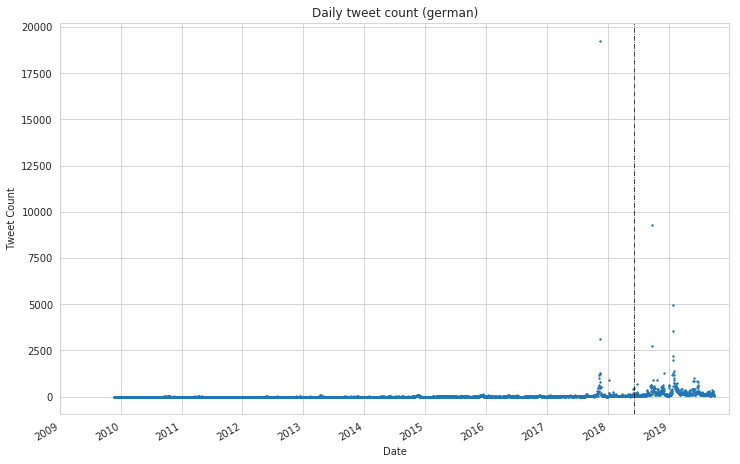

In [28]:
# tweet freq over time
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count, marker='.', s=10, edgecolor=None)
ax.set(xlim=(datetime.datetime.strptime('2009-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')),
       #ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count (german)")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

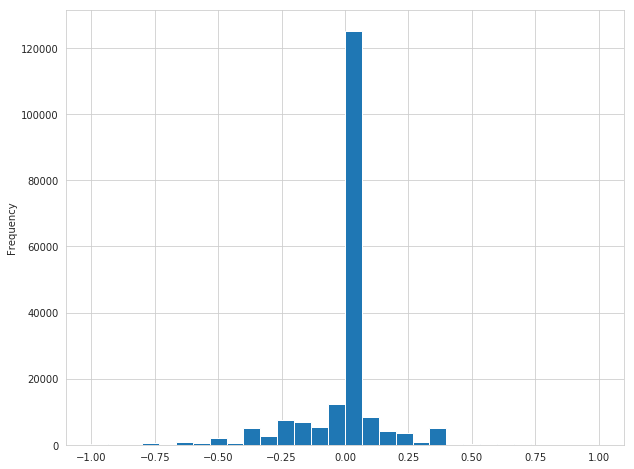

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist(bins=30)

plt.show()

In [30]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

zeitung_energie "Monopolkommission warnt vor Marktmissbrauch durch Kraftwerksbetreiber: Angesichts erwartbarer Verknappungen des Stromangebotes durch Atom- und Kohleausstieg sieht die Monopolkommission die Gefahr von Preismanipulationen. https://t.co/vW5zrNUXV3"
Grüne Vielflieger die Pendlern den #Diesel wegnehmen wollen sind wie ein Heroin-Junkie, der andere mit erhobenem Zeigefinger vor den Gefahren ihres Feierabendbieres warnt...

#dieselfahrverbote #grüne #langstreckenluisa #kohleausstieg
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/du720M9Oyx https://t.co/Uf0WqlT1q3
@oscarmachtmiau @gabido68 @Hallaschka_HH @Luisamneubauer @sciforfuture Es geht um den Kohleausstieg und da sollte man ins Detail gehen. Es geht um Arbeitsplätze und Schicksale. Bei PV Anlagen bin ich bei Ihnen. Windräder müssen umweltfreundlich aufgestellt werden und man muss etwas gegen die Gefahr für die Vögel machen.
Das Paris-Abkommen ist in Gefahr: Seit Jahren wird die Debatte um den 

In [31]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Was für eine gelungene Aktion von @robin_wood und @Ende__Gelaende bzw. @Kokolores_SW am Kohlekraftwerk in Karlsruhe am Hafen. Laut Angaben von EnBW dürfen die AktivistInnen das Gelände bis 17Uhr verlassen ohne ihre Personalien abgeben zu müssen.
#EndeGelaende #Kohleausstieg https://t.co/gW6mLEf62w
Bus bringt Aktivisten @Ende__Gelaende nach gelungener #Kohle-Blockade jetzt nach Aussage @Polizei_NRW_AC zum #klimacamp #EndCoal
Vielen Dank an die Initiatoren und dessen Veranstaltungsteam zur gelungenen Demonstration: Tempo machen beim Kohleausstieg! https://t.co/36kT1xSajy
#Karlsruhe tanzt für den #Kohleausstieg! Was für ein Gelungener Tag. #EndeGelaende #hambibleibt! @Ende__Gelaende… https://t.co/C7UVV3JqwO
RT @R34lB0rg: #Klimaanlagen sind der perfekte #Selbstläufer:
1.) sie pumpen die Hitze nach draussen
2.) sie produzieren zusätzliche Abwärme…
Ontario: Kohleausstieg perfekt @manuelberkel @Reissenw @DENEFFeV @dena_news @drhelmutsoul1 @BIZZenergytoday @IWR_News http://t.co/5hhuWs68EP
@rah

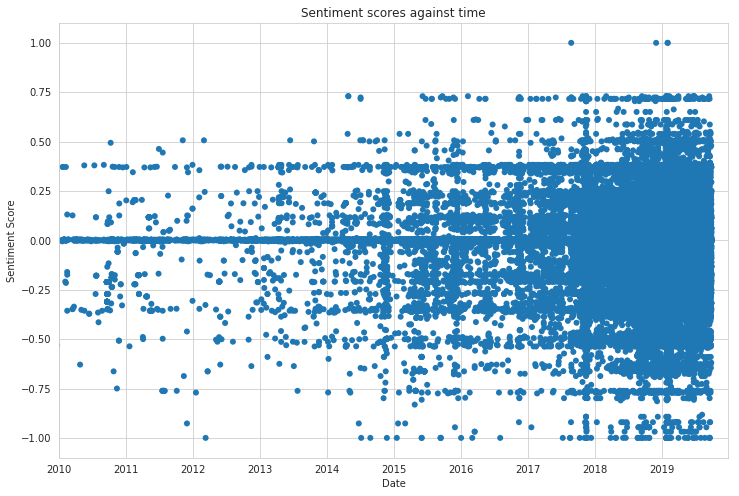

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de['created_at'], texts_de['score'], edgecolor='', ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Sentiment Score", title="Sentiment scores against time")
plt.show()

In [33]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['score'].mean()

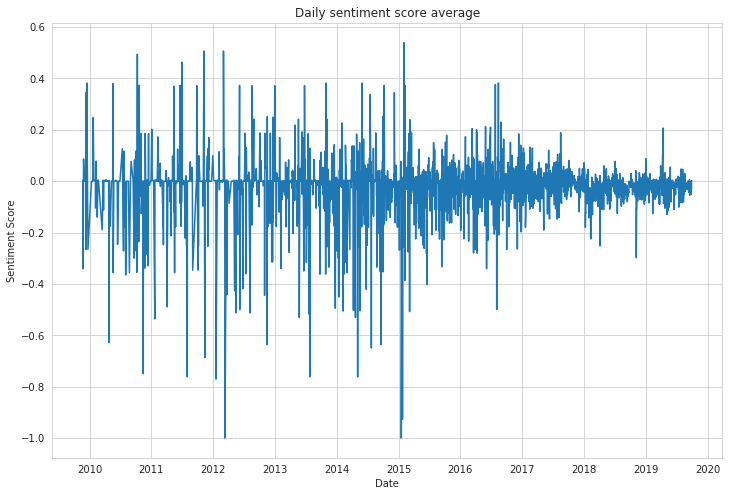

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [35]:
texts_de_monthly = texts_de.groupby(pd.Grouper(key='created_at',freq='M'))['score'].mean()

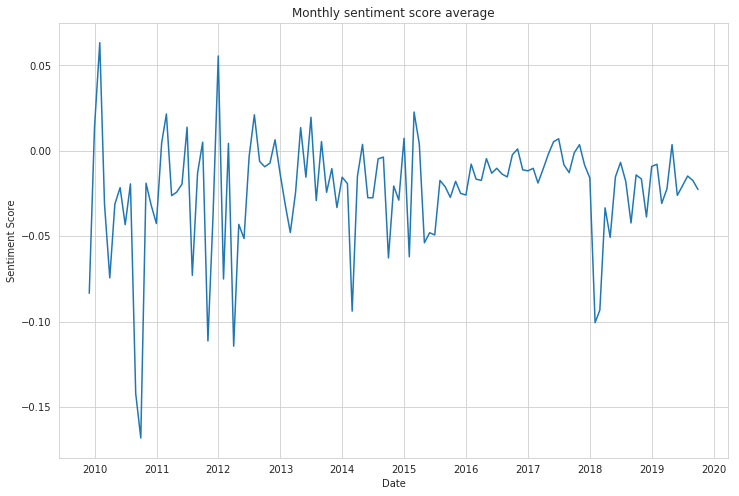

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_monthly.index, texts_de_monthly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Monthly sentiment score average")
plt.show()
#fig.savefig('plots/monthlyavgsenti.png', dpi=300)

In [37]:
texts_de_yearly = texts_de.groupby(pd.Grouper(key='created_at',freq='Y'))['score'].mean()

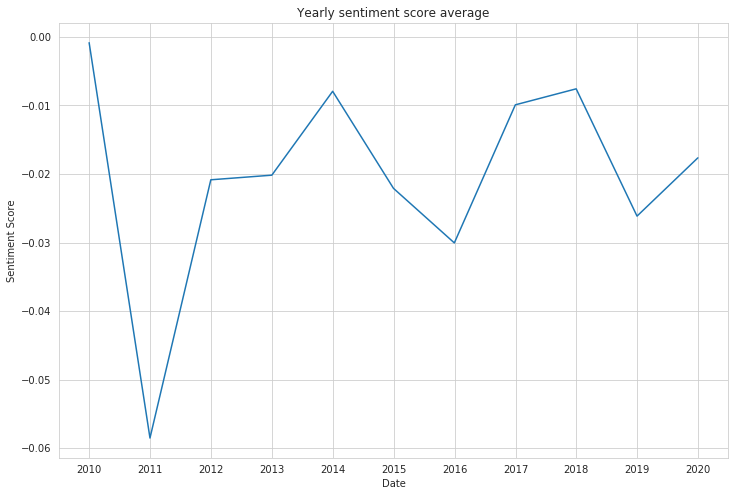

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_yearly.index, texts_de_yearly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Yearly sentiment score average")
plt.show()
#fig.savefig('plots/yearlyavgsenti.png', dpi=300)

### A Closer Look

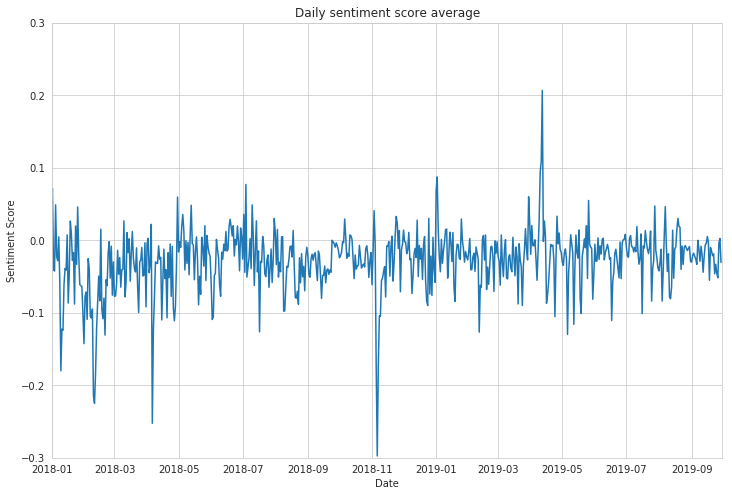

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.3,0.3),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

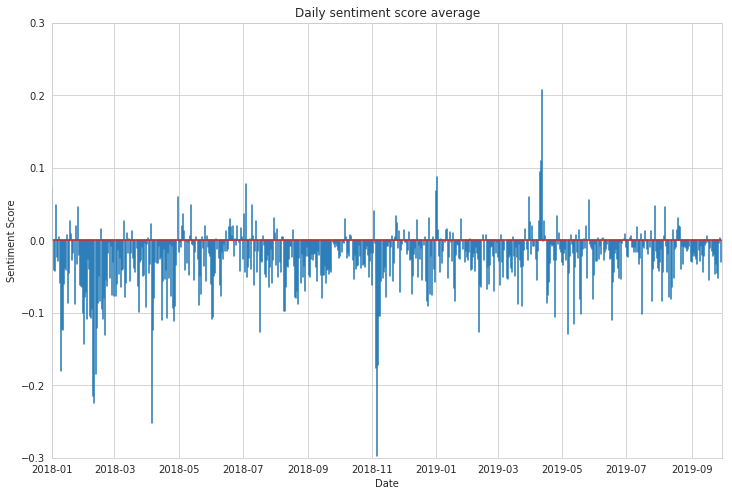

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.3,0.3),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [41]:
start_date = datetime.datetime.strptime('2018-01-01-+0000', '%Y-%m-%d-%z')
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [42]:
date_range = (texts_de_daily.index >= start_date) & (texts_de_daily.index <= end_date)

In [43]:
texts_de_daily[date_range].sort_values(ascending=False)[:5]

created_at
2019-04-12 00:00:00+00:00    0.206995
2019-04-11 00:00:00+00:00    0.109590
2019-04-10 00:00:00+00:00    0.093941
2019-01-02 00:00:00+00:00    0.087450
2018-07-04 00:00:00+00:00    0.077070
Name: score, dtype: float64

In [44]:
texts_de_daily[date_range].sort_values()[:5]

created_at
2018-11-06 00:00:00+00:00   -0.297417
2018-04-06 00:00:00+00:00   -0.252404
2018-02-10 00:00:00+00:00   -0.224872
2018-02-09 00:00:00+00:00   -0.214102
2018-02-11 00:00:00+00:00   -0.184281
Name: score, dtype: float64

In [45]:
positive_day = texts_de['date_only'] == datetime.date(2019,4,12)
positive_day_tweets = texts_de[positive_day]

In [46]:
positive_day_tweets.sort_values(by='score', ascending=False)[:20]

,id,created_at,text,lang,score,date_only
168855,1116706328347598849,2019-04-12 14:15:10+00:00,RT @julia_verlinden: Großartig!👍\n#DieAnstalt ...,de,0.4606,2019-04-12
168878,1116746240664973314,2019-04-12 16:53:46+00:00,@OldTomBom @DaniBrodesser @JoanHoban Eine brei...,de,0.3716,2019-04-12
168838,1116688930756341760,2019-04-12 13:06:02+00:00,Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es...,de,0.3716,2019-04-12
168703,1116590583479275522,2019-04-12 06:35:15+00:00,Guten Morgen! Heute bei @dpa_Ost: BER und die ...,de,0.3716,2019-04-12
168910,1116851597613707265,2019-04-12 23:52:25+00:00,RT @AStipicic: Sehr gut!!! #FridaysForFuture ...,de,0.3716,2019-04-12
168909,1116843257332473857,2019-04-12 23:19:17+00:00,Sehr gut!!! #FridaysForFuture #Klimawandel #...,de,0.3716,2019-04-12
168730,1116609042904784896,2019-04-12 07:48:36+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
168773,1116635658716614664,2019-04-12 09:34:21+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
168762,1116632776827129856,2019-04-12 09:22:54+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
168764,1116633446267392005,2019-04-12 09:25:34+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12


In [47]:
most_pos_day = positive_day_tweets.sort_values(by='score', ascending=False)
for i in most_pos_day.index[:10]:
    print(most_pos_day.loc[i]['text'])

RT @julia_verlinden: Großartig!👍
#DieAnstalt im @ZDF mit "#Scheuermann" auf der Titanic, die ca 6 Grad Celsius vom Kurs nach #Paris abgekom…
@OldTomBom @DaniBrodesser @JoanHoban Eine breite gesellschaftliche Diskussion finde ich sehr gut die aber nicht bei Dieselgate und Kohleausstieg beginnt und auch dort nicht enden darf.

#Ressourcenschonung ist das Zauberwort
Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es wird wieder für einen besseren Klimaschutz und einen früheren Kohleausstieg demonstriert https://t.co/OaBYIrfrki https://t.co/qCPZWoFqmg
Guten Morgen! Heute bei @dpa_Ost: BER und die Frage nach der Eröffnung / Flutung des Ostsees / Reichsbürger-Prozess in Halle / Sachsens Jugendliche und die Jugendweihe / Osterreiseverkehr / Zeitz und der Kohleausstieg /  Bühnenabschied für Gesangsduo Hauff &amp; Henkler? (mow)
RT @AStipicic: Sehr gut!!! #FridaysForFuture  #Klimawandel  #CambioClimático 
Dieses Jahr 2019 in #Chile haben #COP25 #COP25CL 
Hier sagen…
Sehr gut!!! #FridaysForFuture  #

#### @Luisamneubauer
> Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den Kram passt - wäre ja schön blöd nur wegen so ein paar Halbstarken auf einmal echten Klimaschutz durchzusetzen, der wohlmöglich noch dem Parisabkommen entspricht.

https://twitter.com/luisamneubauer/status/1116443797448208402

In [48]:
negative_day = texts_de['date_only'] == datetime.date(2018,11,6)
negative_day_tweets = texts_de[negative_day]

In [49]:
negative_day_tweets.sort_values(by='score')[:20]

,id,created_at,text,lang,score,date_only
107125,1059951748180312065,2018-11-06 23:32:44+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106994,1059813515890962432,2018-11-06 14:23:27+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106993,1059813074675400707,2018-11-06 14:21:42+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
107086,1059893706046750721,2018-11-06 19:42:06+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106979,1059797367984132096,2018-11-06 13:19:17+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106974,1059795039755399169,2018-11-06 13:10:02+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106970,1059788994479820800,2018-11-06 12:46:00+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106967,1059787821920206855,2018-11-06 12:41:21+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
106960,1059784115610939392,2018-11-06 12:26:37+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
107101,1059920115607765003,2018-11-06 21:27:02+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06


In [50]:
most_neg_day = negative_day_tweets.sort_values(by='score')
for i in most_neg_day.index[:10]:
    print(most_neg_day.loc[i]['text'])

RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle od

#### @ARTE:Re:
> Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz immer emotionaler wird. ➡️ http://bit.ly/2AAXTvX #hambi #HambiGehtWeiter 

https://twitter.com/ARTEre/status/1059740775188234240

---

## Looking at specific events

### Launch of coal commission 2018-06-06

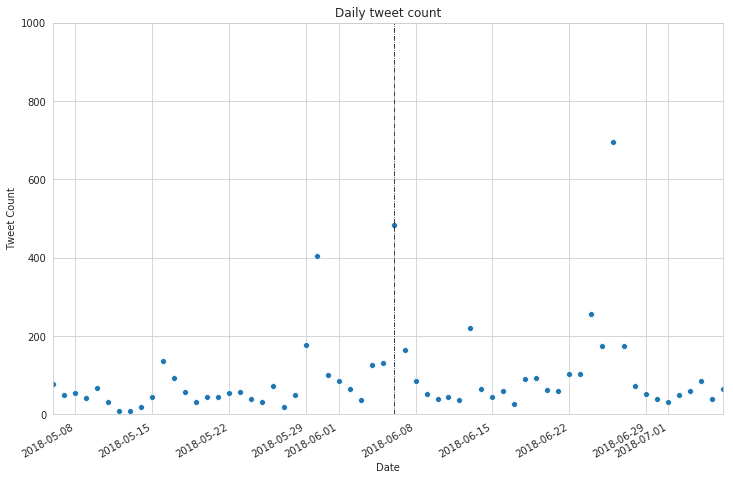

In [56]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), 
             datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

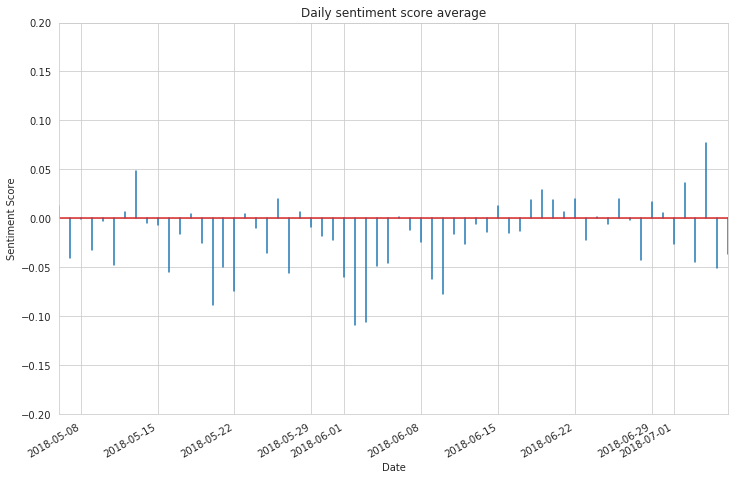

In [57]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
#ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

In [58]:
# tweets 
event1 = texts_de['date_only'] == datetime.date(2018,6,6)
event1_tweets = texts_de[event1]

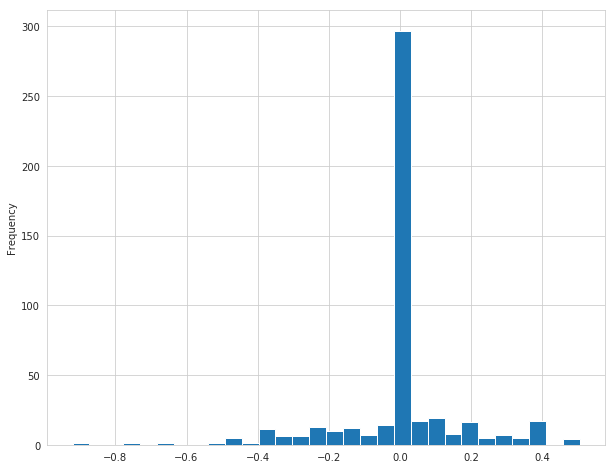

In [59]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event1_tweets['score'].plot.hist(bins=30)

plt.show()

In [60]:
event1_pos = event1_tweets.sort_values(by='score', ascending=False)
for i in event1_pos.index[:10]:
    print(event1_pos.loc[i]['text'])

Piratenpartei RT piratenparteibb: Ganz tolle Besetzung bei der Kohlekommission. Das wird wohl darauf hinaus laufen, dass noch der letzte Euro aus den Tagebauen gebuddelt wird und die Allgemeinheit dann auf den Renaturierungskosten mit einer zusammen brec… https://t.co/f2AFPL001K
Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/3369hC4Bt3
📋 Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/cgt6iejaFq ❚DIHK
@zukunft_erdgas Kohle ist ein Geschenk von Mutter Natur an den Menschen, um genutzt zu werden. Wir brauchen mehr Kohleabbau statt Kohleausstieg. #Kohlekommission https://t.co/ei0pjaWeAe
Heute wird die #Kohlekomission vom Bundeskabinett berufen. Mut zur Lücke braucht sie sicherlich nicht 😉 Denn bei aktuellem Trend würde die Lücke zu unseren #Klimaschutz-Zielen von alleine immer größer.  Mut zum #Kohleausstieg! https://t.co/L7dTcmPjCI
Gleichzeitig müssen Perspektiven für Regionen geschaffen werden, wo die Kohleindustrie wichtigster Arbeitgeber ist. Kohle

In [61]:
event1_neg = event1_tweets.sort_values(by='score')
for i in event1_neg.index[:10]:
    print(event1_neg.loc[i]['text'])

Wie Kohleausstieg @DFoest ? Atomkraft ist fast weg. Was sollen wir nachts bei schwachem Wind tun? Oder von Oktober bis Februar 16-10 Uhr? https://t.co/8rPQRD3VTD
Heute Start der #Kohlekommission. Vergoldung längst geplanter Abschaltungen!! Betroffene haben kein Gewicht in WBS, müssen schlechte Entscheidungen mittragen. Was sind Roten Linien, bei denen ihr aus WBS aussteigt? @bund_net @greenpeace_de @DNR_EUnews
https://t.co/jPx7uPWJCG
Die Einsetzung einer #Kohlekommission in der keines der Worte #Kohleausstieg, #Klimaschutz oder #Energiewende im Titel vorkommen - finde den Fehler!
Bitte, @tt_embrace! Und jetzt sagen wir mit dem #RC18 der #Kanzlerin und der #Kohlekommission dem Kampf an! :) https://t.co/RmB864mL6D
#Kohlekommission Hier werden die grünen Verweigerer wieder mal zum Gutachter gemacht. Merkel vernichtet dadurch weitere Tausende Arbeitsplätze.
Wenn die #Kohlekommission sich nicht damit befasst, warum ich immer wieder zu wenig #Kohle habe, ist sie sowieso nutzlos.
Schellnhuber

### Launch of report 2019-01-26

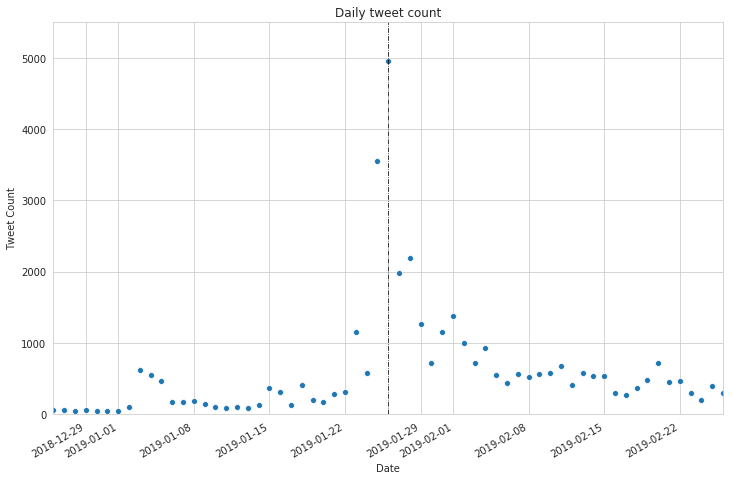

In [65]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(0,5500),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

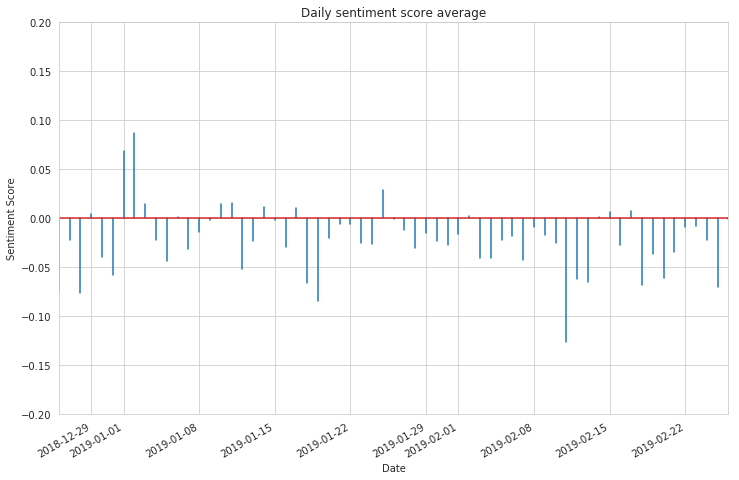

In [66]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [67]:
# tweets 
event2 = texts_de['date_only'] == datetime.date(2019,1,26)
event2_tweets = texts_de[event2]

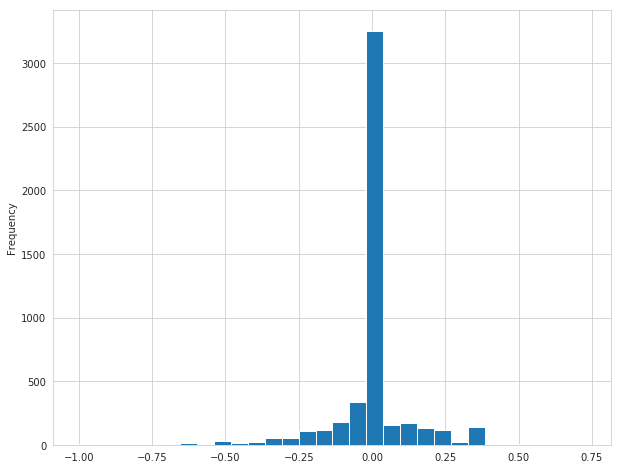

In [68]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event2_tweets['score'].plot.hist(bins=30)

plt.show()

In [69]:
event2_pos = event2_tweets.sort_values(by='score', ascending=False)
for i in event2_pos.index[:10]:
    print(event2_pos.loc[i]['text'])

Perfekte Idiotie! Die infantile Republik... (und diejenigen, die die Infantilität der anderen für ihre Agenda benutzen...)
#Kohleausstieg #FridaysForFuture #Kohleausstieg https://t.co/XMH2noU7A1
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUtaf9
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUKLDJ
Ganz dickes Lob an @WDR für diesen Beitrag! #Kohlekommission #Braunkohle - 
@anettselle @wdanslesnuages @klimareport @klimacamp @ImkeByl @MonaNeubaur @bund_net @greenpeace_de @WWF_Deutschland @Ende__Gelaende  @FridayForFuture - #Energiewende muss global angegangen werden! https://t.co/WdIRCz7n3N
@rossreiter @GSiebeke @fuecks Es ist immer sehr spannend zu beobachten, wie die Menschen sich ihre Welt selber in #Ideologen und #Befürworter einteilen

"Und was ist Dein Bei

In [70]:
event2_neg = event2_tweets.sort_values(by='score')
for i in event2_neg.index[:10]:
    print(event2_neg.loc[i]['text'])

Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - Foto: Ruhrgebiet, über dts NachrichtenagenturBerlin (dts Nachrichtenagentur) - -
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/pIYw1OvNoM https://t.co/BKvJE3t34A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr
 #nachrichten
 https://t.co/HoPrQpxM4A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/N44Gnixr88
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/du720M9Oyx https://t.co/Uf0WqlT1q3
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/zwaLxygYpp
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/eCJyXydQWb https://t.co/uHCvNBnYwz
@eysvog3l Gestern wurde in #Kohlekommission der Industriestandort 🇩🇪 von @peteraltmaier @BMWi_Bund beerdigt! 

Wer solche Arbeitervertreter wie @igbce @IGMetall Vorsitzenden &amp; seine #spd #bundestag Trulla @FahimiYasmin hat, braucht keine Feinde

### Hambach Forest debate 2018-10-05
> "Court rules clearing operations at Hambach Forest have to be stopped" - CEW

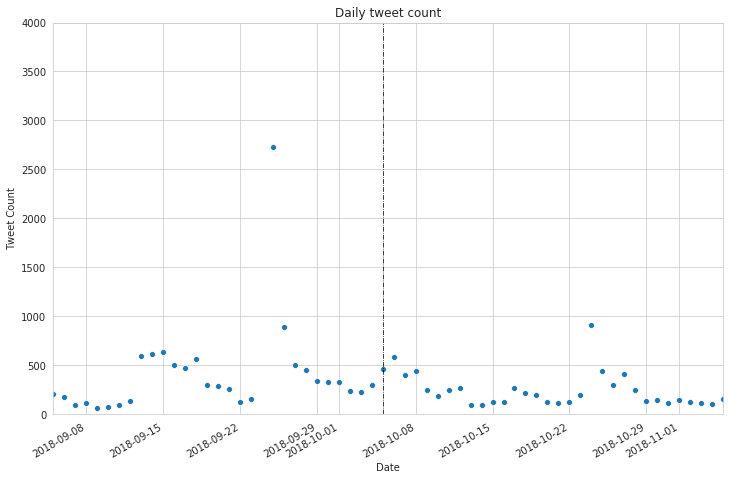

In [71]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(0,4000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-10-05', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

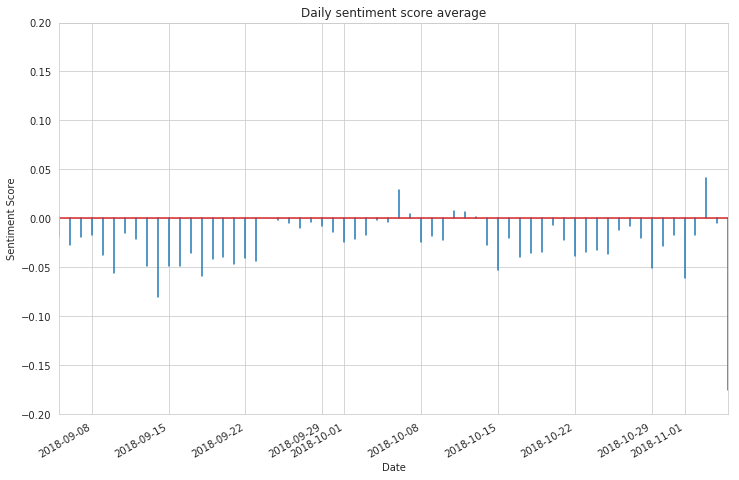

In [72]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [73]:
# tweets 
event3 = texts_de['date_only'] == datetime.date(2018,10,5)
event3_tweets = texts_de[event3]

In [74]:
event3_pos = event3_tweets.sort_values(by='score', ascending=False)
for i in event3_pos.index[:10]:
    print(event3_pos.loc[i]['text'])

Letzter Aufruf - spannender Kinoabend heute in Kerpen bei Köln! Wir zeigen "Wackersdorf", Regisseur Oliver Haffner ist vor Ort und es gibt noch Rest-Tickets! Um Anmeldung wird gebeten! #hambi #kohlefrei @WWF_Deutschland @LichtBlick_de @AlamodeFilm https://t.co/NnVCydhEHa
Heute nur Freude – #Rodungsstopp und kein #Demonstrationsverbot @bund_net // #Bechsteinfledermaus #Fledermaus #Hambacherforst/.org #Hambibleibt #Hambach #Tagebau, #RWE #coalmining#Oaktown #Kohleausstieg #DivestCoal #endcoal #nocoal… https://t.co/923wjPmYXx https://t.co/DrDUMIYeYh
ich könnte heulen vor Freude. 
#hambibleibt #HambacherForst #fckrwe #nrwe #Kohleausstieg
https://t.co/8ZgApN1Bkp
Vorläufiger Rodungsstopp im #HambacherForst ist super, ABER eben noch nicht endgültig.
Deshalb bleibts dabei: Morgen Demo am Wald - für #Kohleausstieg und #Hambibleibt!
#Kohle #Energiewende https://t.co/tUyyZFa9n2
hey SUPER Song und super Text- könnten wir vielleicht in unser Ökumenisches-Klimapilgern-Lieder-undTexte-Buch aufnehmen:

In [75]:
event3_neg = event3_tweets.sort_values(by='score')
for i in event3_neg.index[:10]:
    print(event3_neg.loc[i]['text'])

@Richard69367829 @cem_oezdemir Du vergleichst hier Äpfel mit Birnen, das eine ist ein Privatgrundstück, welches auch nicht vom Eigentümer so verändert werden soll, dass es für die Bevölkerung schädlich ist. Das andere ein öffentlicher Wald, welcher für Klimaschädliche Kohle zerstört werden soll.
#hambibleibt
Wald oder Kohle? Streit um den Hambacher Forst | Wir diskutieren mit @ArminLaschet, @SvenjaSchulze68, @c_lindner, Anton Hofreiter, Antje Grothus und Michael Vassiliadis. #AnneWill | Sonntag 21:45 @DasErste. #HambacherForst https://t.co/NF4a9FQ8o2
Für diejenigen, die noch nicht einordnen können, dass es beim #HambacherForst  nicht nur "um ein paar Baumhäuser" und "ein Stück Urwald" geht:

Quarks - Der Streit um die Braunkohle

https://t.co/R2jjQkGqo4

#HambiBleibt
#Kohleausstieg #Klimawandel
Großdemo für den #HambacherForst in Buir verboten. Wir gehen trotzdem auf die Straße. Hier die Route der Solidemo morgen um 14 Uhr ab Richardplatz in #Berlin.
Kohle stoppen - #hambibleibt
=&gt; 